In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d virtualdvid/oregon-wildlife

 99% 4.52G/4.55G [00:20<00:00, 268MB/s]
100% 4.55G/4.55G [00:20<00:00, 237MB/s]


In [3]:
import zipfile 
zip_ref=zipfile.ZipFile('/content/oregon-wildlife.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
image_exts = ['jpeg','jpg','png']
data_dir='/content/oregon_wildlife/oregon_wildlife'

In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in exist list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

Image not in exist list /content/oregon_wildlife/oregon_wildlife/seals/5417e8ff67248c3ba3.jpg
Image not in exist list /content/oregon_wildlife/oregon_wildlife/seals/da5fbf3809d8110fea.gif
Image not in exist list /content/oregon_wildlife/oregon_wildlife/seals/cb978b9e4fdf3fc8af.jpeg
Image not in exist list /content/oregon_wildlife/oregon_wildlife/seals/4d7d08419287b7eaf6.gif
Image not in exist list /content/oregon_wildlife/oregon_wildlife/seals/0be62f19e16cd8247d.jpg
Image not in exist list /content/oregon_wildlife/oregon_wildlife/seals/3065d6b0068d1d8c37.gif
Image not in exist list /content/oregon_wildlife/oregon_wildlife/seals/0f56b82d340b036e44.jpg
Image not in exist list /content/oregon_wildlife/oregon_wildlife/seals/5ef0a1c8254fcd89b8.jpeg
Image not in exist list /content/oregon_wildlife/oregon_wildlife/seals/feee22d13b4db2a0b9.jpg
Image not in exist list /content/oregon_wildlife/oregon_wildlife/seals/ab9bd73a0cf50c894f.jpg
Image not in exist list /content/oregon_wildlife/oregon_wi

In [6]:
import tensorflow as tf
import cv2
import imghdr
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders # or import splitfolders
input_folder = "/content/oregon_wildlife/oregon_wildlife"
output = "/content/WildLife" #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .1, .1)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example

Copying files: 13094 files [00:47, 276.10 files/s]


In [8]:
data = keras.utils.image_dataset_from_directory(
    directory = '/content/oregon_wildlife/oregon_wildlife',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(224,224)
)


Found 13637 files belonging to 20 classes.


In [9]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()


In [10]:
data = data.map(lambda x,y: (x/255, y))

In [11]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.1)
test_size = int(len(data)*.1)
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [12]:
conv_base=tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
    )
conv_base.trainable=False

94668760/94668760 [==============================] - 0s 0us/step


In [13]:
conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [14]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(20, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 32)                3211296   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                660       
                                                                 
Total params: 26,776,756
Trainable params: 3,211,956
Non-trainable params: 23,564,800
_________________________________________________________________


In [16]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',    
    min_delta = 0,
    patience = 8,
    verbose = 0, 
    restore_best_weights = True)

In [18]:
# Train the network
history = model.fit(train,
                 epochs=60, 
                 validation_data=val,
                 callbacks=[early_stopping])

Epoch 1/60
298/298 [==============================] - 216s 681ms/step - loss: 2.5001 - accuracy: 0.2710 - val_loss: 2.1615 - val_accuracy: 0.3504
Epoch 2/60
298/298 [==============================] - 189s 630ms/step - loss: 2.0927 - accuracy: 0.3656 - val_loss: 1.8755 - val_accuracy: 0.4129
Epoch 3/60
298/298 [==============================] - 187s 620ms/step - loss: 1.7225 - accuracy: 0.4416 - val_loss: 1.4461 - val_accuracy: 0.5484
Epoch 4/60
298/298 [==============================] - 188s 621ms/step - loss: 1.3964 - accuracy: 0.5364 - val_loss: 1.2498 - val_accuracy: 0.6116
Epoch 5/60
298/298 [==============================] - 185s 614ms/step - loss: 1.2581 - accuracy: 0.5659 - val_loss: 1.1862 - val_accuracy: 0.5930
Epoch 6/60
298/298 [==============================] - 185s 615ms/step - loss: 1.1706 - accuracy: 0.6064 - val_loss: 1.1859 - val_accuracy: 0.6436
Epoch 7/60
298/298 [==============================] - 187s 622ms/step - loss: 1.0944 - accuracy: 0.6284 - val_loss: 1.1670 -

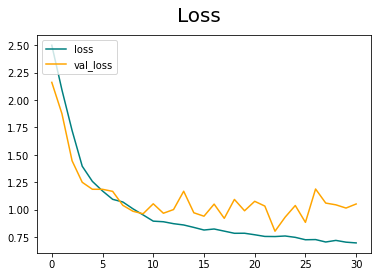

In [19]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

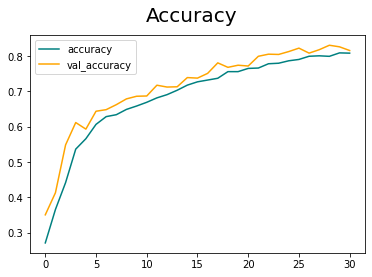

In [20]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [21]:
model.save('UpdatedWildLifeClassifier.h5')